**Narit Trikasemsak**

Spring 2023

CS 251/2: Data Analysis and Visualization

Project 6: Supervised learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 3: Preprocess full spam email dataset 

Before you build a Naive Bayes spam email classifier, run the full spam email dataset through your preprocessing code.

Download and extract the full **Enron** emails (*zip file should be ~29MB large*). You should see a base `enron` folder, with `spam` and `ham` subfolders when you extract the zip file (these are the 2 classes).

Run the test code below to check everything over.

### 3a) Preprocess dataset

In [2]:
import email_preprocessor as epp

#### Test `count_words` and `find_top_words`

In [3]:
word_freq, num_emails = epp.count_words()

In [4]:
print(f'You found {num_emails} emails in the datset. You should have found 32625.')

You found 32625 emails in the datset. You should have found 32625.


In [5]:
top_words, top_counts = epp.find_top_words(word_freq)
print(f"Your top 5 words are\n{top_words[:5]}\nand they should be\n['the', 'to', 'and', 'of', 'a']")
print(f"The associated counts are\n{top_counts[:5]}\nand they should be\n[277459, 203659, 148873, 139578, 111796]")

Your top 5 words are
['the', 'to', 'and', 'of', 'a']
and they should be
['the', 'to', 'and', 'of', 'a']
The associated counts are
[277459, 203659, 148873, 139578, 111796]
and they should be
[277459, 203659, 148873, 139578, 111796]


### 3b) Make train and test splits of the dataset

Here we divide the email features into a 80/20 train/test split (80% of data used to train the supervised learning model, 20% we withhold and use for testing / prediction).

In [8]:
features, y = epp.make_feature_vectors(top_words, num_emails)

In [9]:
np.random.seed(0)
x_train, y_train, inds_train, x_test, y_test, inds_test = epp.make_train_test_sets(features, y)

In [10]:
print('Shapes for train/test splits:')
print(f'Train {x_train.shape}, classes {y_train.shape}')
print(f'Test {x_test.shape}, classes {y_test.shape}')
print('\nThey should be:\nTrain (26100, 200), classes (26100,)\nTest (6525, 200), classes (6525,)')

Shapes for train/test splits:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)

They should be:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)


### 3c) Save data in binary format

It adds a lot of overhead to have to run through your raw email -> train/test feature split every time you wanted to work on your project! In this step, you will export the data in memory to disk in a binary format. That way, you can quickly load all the data back into memory (directly in ndarray format) whenever you want to work with it again. No need to parse from text files!

Running the following cell uses numpy's `save` function to make six files in `.npy` format (e.g. `email_train_x.npy`, `email_train_y.npy`, `email_train_inds.npy`, `email_test_x.npy`, `email_test_y.npy`, `email_test_inds.npy`).

In [11]:
np.save('data/email_train_x.npy', x_train)
np.save('data/email_train_y.npy', y_train)
np.save('data/email_train_inds.npy', inds_train)
np.save('data/email_test_x.npy', x_test)
np.save('data/email_test_y.npy', y_test)
np.save('data/email_test_inds.npy', inds_test)

## Task 4: Naive Bayes Classifier

After finishing your email preprocessing pipeline, implement the one other supervised learning algorithm we we will use to classify email, **Naive Bayes**.

### 4a) Implement Naive Bayes

In `naive_bayes.py`, implement the following methods:
- Constructor
- get methods
- `train(data, y)`: Train the Naive Bayes classifier so that it records the "statistics" of the training set: class priors (i.e. how likely an email is in the training set to be spam or ham?) and the class likelihoods (the probability of a word appearing in each class — spam or ham).
- `predict(data)`: Combine the class likelihoods and priors to compute the posterior distribution. The predicted class for a test sample is the class that yields the highest posterior probability.
- `accuracy(y, y_pred)`: The usual definition :)


#### Bayes rule ingredients: Priors and likelihood (`train`)

To compute class predictions (probability that a test example belong to either spam or ham classes), we need to evaluate **Bayes Rule**. This means computing the priors and likelihoods based on the training data.

**Prior:** $$P_c = \frac{N_c}{N}$$ where $P_c$ is the prior for class $c$ (spam or ham), $N_c$ is the number of training samples that belong to class $c$ and $N$ is the total number of training samples.

**Likelihood:** $$L_{c,w} = \frac{N_{c,w} + 1}{N_{c} + M}$$ where
- $L_{c,w}$ is the likelihood that word $w$ belongs to class $c$ (*i.e. what we are solving for*)
- $N_{c,w}$ is the total count of **word $w$** in emails that are only in class $c$ (*either spam or ham*)
- $N_{c}$ is the total number of **all words** that appear in emails of the class $c$ (*total number of words in all spam emails or total number of words in all ham emails*)
- $M$ is the number of features (*number of top words*).

#### Bayes rule ingredients: Posterior (`predict`)

To make predictions, we now combine the prior and likelihood to get the posterior:

**Log Posterior:** $$Log(\text{Post}_{i, c}) = Log(P_c) + \sum_{j \in J_i}x_{i,j}Log(L_{c,j})$$

 where
- $\text{Post}_{i,c}$ is the posterior for class $c$ for test sample $i$(*i.e. evidence that email $i$ is spam or ham*). We solve for its logarithm.
- $Log(P_c)$ is the logarithm of the prior for class $c$.
- $x_{i,j}$ is the number of times the jth word appears in the ith email.
- $Log(L_{c,j})$: is the log-likelihood of the jth word in class $c$.

In [12]:
from naive_bayes import NaiveBayes

#### Test `train`

###### Class priors and likelihoods

The following test should be used only if storing the class priors and likelihoods directly.

In [26]:
num_test_classes = 4
np.random.seed(0)
data_test = np.random.randint(low=0, high=20, size=(100, 6))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_test, y_test)

print(f'Your class priors are: {nbc.get_priors()}\nand should be          [0.28 0.22 0.32 0.18].')
print(f'Your class likelihoods shape is {nbc.get_likelihoods().shape} and should be (4, 6).')
print(f'Your likelihoods are:\n{nbc.get_likelihoods()}')

print(f'and should be')
print('''[[0.15997 0.15091 0.2079  0.19106 0.14184 0.14832]
 [0.11859 0.16821 0.17914 0.16905 0.18082 0.18419]
 [0.16884 0.17318 0.14495 0.14332 0.18784 0.18187]
 [0.16126 0.17011 0.15831 0.13963 0.18977 0.18092]]''')

Your class priors are: [0.28 0.22 0.32 0.18]
and should be          [0.28 0.22 0.32 0.18].
Your class likelihoods shape is (4, 6) and should be (4, 6).
Your likelihoods are:
[[0.15997 0.15091 0.2079  0.19106 0.14184 0.14832]
 [0.11859 0.16821 0.17914 0.16905 0.18082 0.18419]
 [0.16884 0.17318 0.14495 0.14332 0.18784 0.18187]
 [0.16126 0.17011 0.15831 0.13963 0.18977 0.18092]]
and should be
[[0.15997 0.15091 0.2079  0.19106 0.14184 0.14832]
 [0.11859 0.16821 0.17914 0.16905 0.18082 0.18419]
 [0.16884 0.17318 0.14495 0.14332 0.18784 0.18187]
 [0.16126 0.17011 0.15831 0.13963 0.18977 0.18092]]


###### Log of class priors and likelihoods

This test should be used only if storing the log of the class priors and likelihoods.

In [ ]:
num_test_classes = 4
np.random.seed(0)
data_test = np.random.randint(low=0, high=20, size=(100, 6))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_test, y_test)

print(f'Your log class priors are: {nbc.get_priors()}\nand should be              [-1.27297 -1.51413 -1.13943 -1.7148 ].')
print(f'Your log class likelihoods shape is {nbc.get_likelihoods().shape} and should be (4, 6).')
print(f'Your log likelihoods are:\n{nbc.get_likelihoods()}')


print(f'and should be')
print('''[[-1.83274 -1.89109 -1.57069 -1.65516 -1.95306 -1.90841]
 [-2.13211 -1.78255 -1.71958 -1.77756 -1.71023 -1.6918 ]
 [-1.77881 -1.75342 -1.93136 -1.94266 -1.67217 -1.70448]
 [-1.82475 -1.77132 -1.84321 -1.96879 -1.66192 -1.70968]]''')

#### Test `predict`

In [37]:
num_test_classes = 4
np.random.seed(0)
data_train = np.random.randint(low=0, high=num_test_classes, size=(100, 10))
data_test = np.random.randint(low=0, high=num_test_classes, size=(15, 10))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_train, y_test)
test_y_pred = nbc.predict(data_test)

print(f'Your predicted classes are\n{test_y_pred}\nand should be\n[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]')

Your predicted classes are
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]
and should be
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]


### 4b) Spam filtering

Let's start classifying spam email using the Naive Bayes classifier. The following code uses `np.load` to load in the train/test split that you created last week.
- Use your Naive Bayes classifier on the Enron email dataset!

**Question 7:** Print out the accuracy that you get on the test set with Naive Bayes. It should be roughly 89%.

In [38]:
import email_preprocessor as ep

In [139]:
x_train = np.load('data/email_train_x.npy')
y_train = np.load('data/email_train_y.npy')
inds_train = np.load('data/email_train_inds.npy')
x_test = np.load('data/email_test_x.npy')
y_test = np.load('data/email_test_y.npy')
inds_test = np.load('data/email_test_inds.npy')

In [140]:
enron_nbc = NaiveBayes(num_classes=2)
enron_nbc.train(x_train, y_train)

enron_pred = enron_nbc.predict(x_test)
enron_acc = enron_nbc.accuracy(y_test, enron_pred)
print("Accuracy is", enron_acc, "%")

Accuracy is 89.24137931034483 %


We get an accuracy of roughly 89% as desired

### 4c) Confusion matrix

To get a better sense of the errors that the Naive Bayes classifer makes, you will create a confusion matrix. 

- Implement `confusion_matrix` in `naive_bayes.py`.
- Print out a confusion matrix of the spam classification results.

**Debugging guidelines**:
1. The sum of all numbers in your 2x2 confusion matrix should equal the number of test samples (6525).
2. The sum of your spam row should equal the number of spam samples in the test set (3193)
3. The sum of your ham row should equal the number of spam samples in the test set (3332)

In [53]:
matrix = enron_nbc.confusion_matrix(y_test, enron_pred)
print(matrix)

[[3043.  150.]
 [ 552. 2780.]]


**Question 8:** Interpret the confusion matrix, using the convention that positive detection means spam (*e.g. a false positive means classifying a ham email as spam*). What types of errors are made more frequently by the classifier? What does this mean (*i.e. X (spam/ham) is more likely to be classified than Y (spam/ham) than the other way around*)?

**Reminder:** Look back and make sure you are clear on which class indices correspond to spam/ham.

**Answer 8:**

I did not do my class indices alphabetically, so spam is 0 and ham is 1. Then, that means that the top right corner is true spam vs predicted ham, or false negatives. The bottom left corner is false positive, true ham as predicted spam. 

We see that out of 3193 true spam, we classified 150 as ham = 4.69% false negative rate. 

At the same time, out of 3332 true ham, we classified 552 as spam = 16.57% false positive rate. 

Looking at the confusion matrix, we see that there are more false positives than negatives, ie. ham is more likely to be classified as spam than the other way around. 

## Task 5: Comparison with KNN


- Run a similar analysis to what you did with Naive Bayes above. When computing accuracy on the test set, you may want to reduce the size of the test set (e.g. to the first 500 emails in the test set).
- Copy-paste your `confusion_matrix` method into `knn.py` so that you can run the same analysis on a KNN classifier.

In [68]:
from knn import KNN

In [141]:
enron_knn = KNN(2)
enron_knn.train(x_train, y_train)

In [144]:
knn_pred = enron_knn.predict(x_test, 2)
knn_acc = enron_knn.accuracy(y_test, knn_pred)
print("KNN has an accuracy of", knn_acc*100, "%")

KNN has an accuracy of 91.14176245210727 %


In [74]:
matrix = enron_knn.confusion_matrix(y_test, knn_pred)
print(matrix)

[[3117.   76.]
 [ 502. 2830.]]


**Question 9:** What accuracy did you get on the test set (potentially reduced in size)?

**Question 10:** How does the confusion matrix compare to that obtained by Naive Bayes (*If you reduced the test set size, keep that in mind*)?

**Question 11:** Briefly describe at least one pro/con of KNN compared to Naive Bayes on this dataset.

**Question 12:** When potentially reducing the size of the test set here, why is it important that we shuffled our train and test set?

**Answer 9:** 

I did not reduce test set size and got an accuracy of about 91.14%. 

**Answer 10:** 

From initial impressions it seems like the confusion matrix shows slighly less false positives and false negatives compared to Naive Bayes. 

We got a false negative rate of about 2.38%, which is almost halved compared the naive bayes. 

We got a false positive rate about 15.06%, which is slightly less than the naive bayes. 

**Answer 11:** 

One con of KNN compared to Naive Bayes on this dataset is that it is much more computationally expensive to classify with KNN. This is shown by how much longer it took to train the KNN (1 minute) vs the Naive Bayes (1.6 seconds).

One pro of KNN in this situation is higher accuracy as well as the much better false negative and slightly better false positive rate. This could be due to the structure of KNN not assuming that each word is independent of each other, which makes sense given that words are often associated with the ones that come before it. 

**Answer 12:** 

It is important because the shuffling of the train and test set mean that the data, ie. spam and ham emails, are randomly distributed across both sets which means that the two sets are more representative of the population it came from.

## Extensions

### 0. Classify your own datasets

- Find datasets that you find interesting and run classification on them using your KNN algorithm (and if applicable, Naive Bayes). Analysis the performance of your classifer.

## Extension: Wine Quality dataset

For this extension, I wanted to use the wine qualtiy dataset because it has been something I explored in previous projects, and now with the introduction of classification, finally have the tools to tackle the "quality" part. For reference, the wine datast is described as follows from previous projects: 

The wine quality dataset is a large dataset with a number of variables. It looks at red Portuguese "Vinho Verde" wine. The variables include physicochemical (inputs) and sensory (the output). They are: 

   1 - fixed acidity

   2 - volatile acidity

   3 - citric acid

   4 - residual sugar

   5 - chlorides

   6 - free sulfur dioxide
   
   7 - total sulfur dioxide

   8 - density

   9 - pH

   10 - sulphates

   11 - alcohol
   
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)


When I ran PCA on the wine quality in prior projects I found that the variance was most explained by these 5 variables: 

['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide']

To keep to a rasonable computation time, I will choose only these 5 as my features, and then have quality as the label.

In [182]:
df = pd.read_csv("data/winequality-red.csv")
df = df.drop(0)

I select the features

In [183]:
wine_feats = df[['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide']]
wine_labels = df["quality"]
wine_feats

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide
1,7.4,0.7,0,0.076,11
2,7.8,0.88,0,0.098,25
3,7.8,0.76,0.04,0.092,15
4,11.2,0.28,0.56,0.075,17
5,7.4,0.7,0,0.076,11
...,...,...,...,...,...
1595,6.2,0.6,0.08,0.09,32
1596,5.9,0.55,0.1,0.062,39
1597,6.3,0.51,0.13,0.076,29
1598,5.9,0.645,0.12,0.075,32


I do the standard 80/20 test split on it

In [184]:
wine_feats = wine_feats.to_numpy(dtype=float)
wine_labels = wine_labels.to_numpy(dtype=float)

In [185]:
inds = np.arange(wine_labels.size)

wine_feats = wine_feats.copy()
y = wine_labels.copy()

inds = np.arange(y.size)
np.random.shuffle(inds)
wine_feats = wine_feats[inds]
y = y[inds]

# Your code here:

train = int(wine_feats.shape[0] * (0.8))

x_train = wine_feats[:train, :]
y_train = y[:train]

x_test = wine_feats[train:, :]
y_test = y[train:]

print("x train shape", x_train.shape)
print("y train shape", y_train.shape)
print("x test shape", x_test.shape)
print("y test shape", y_test.shape)


x train shape (1279, 5)
y train shape (1279,)
x test shape (320, 5)
y test shape (320,)


And the labels..

however, looking at the data, we see that not all of the classes are use. Thus, we take the number of unique ones to narrow it down.

In [159]:
display(wine_labels)
print(np.unique(wine_labels))

1       5
2       5
3       5
4       6
5       5
       ..
1595    5
1596    6
1597    6
1598    5
1599    6
Name: quality, Length: 1599, dtype: object

['3' '4' '5' '6' '7' '8']


I also have to normalize my features. For ease of use, I decided to find use the preprocessing module available from sklearn

In [186]:
from sklearn import preprocessing

wine_feats = preprocessing.normalize(wine_feats)

So we see that we have 6 unique classes. Equipped with these, I then run KNN classification on it.

In [198]:
wine_knn = KNN(num_classes=6)
wine_knn.train(x_train, y_train)
y_wine_pred = wine_knn.predict(x_test, 5)

In [199]:
acc = wine_knn.accuracy(y_test, y_wine_pred)
print("we get an accuracy of ", acc*100, "%")

we get an accuracy of  46.5625 %


We get an accuracy of about 46.56% from this dataset which is pretty good considering there are 6 seperate classes. So, our classifier is performing better than random choice!

We view the confusion matrix to see the breakdown of predictions vs truth values

In [202]:
mat = wine_knn.confusion_matrix(y_test, y_wine_pred)
mat

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  1.,  0.,  7.],
       [ 0.,  0.,  0.,  0.,  3., 82.]])

Now, we run it on Naive Bayes to see the performance comparison.

In [205]:
wine_knn = NaiveBayes(num_classes=6)
wine_knn.train(x_train, y_train)
y_wine_pred = wine_knn.predict(x_test)
acc = wine_knn.accuracy(y_test, y_wine_pred)
print("we get an accuracy of ", acc, "%")

we get an accuracy of  42.1875 %


We get a slightly lower accruacy of 42.19% which might be explained by a similar reason where the Naive Bayes assumes everytihng is independent, however, if we look at our feature names a lot of them are acidity which indicates that they might have some relationship between each other.


Overall, this was an interesting experiment to see how our classifier would perform on numeric data with more features. Again, our KNN performs slightly better than the Naive Bayes. 

### 1. Better text preprocessing

- If you look at the top words extracted from the email dataset, many of them are common "stop words" (e.g. a, the, to, etc.) that do not carry much meaning when it comes to differentiating between spam vs. non-spam email. Improve your preprocessing pipeline by building your top words without stop words. Analyze performance differences.

### 2. Feature size

- Explore how the number of selected features for the email dataset influences accuracy and runtime performance.

### 3. Distance metrics
- Compare KNN performance with the $L^2$ and $L^1$ distance metrics

### 4. K-Fold Cross-Validation

- Research this technique and apply it to data and your KNN and/or Naive Bayes classifiers.

## Extension: k-fold cross-validation

For this extension, I wanted to implement k-fold cross validation to better evaluate the performance of the model compared to the test/train split that we were using. I reesarched online and found the procedure to be:

Shuffle the dataset randomly.

Split the dataset into k groups

For each unique group:

    Take the group as a hold out or test data set

    Take the remaining groups as a training data set

    Fit a model on the training set and evaluate it on the test set

    Retain the evaluation score and discard the model
    
Summarize the skill of the model using the sample of model evaluation scores

I implemented this in my Naive Bayes classifier for faster run times and evaluate the metrics produced compared to train/test below:

In [81]:
print(features.shape)
kfold = NaiveBayes(2)
kfold.kfold(features, y, 3)

(32625, 200)
start 0 end 10875
test (10875, 200)
train (21750, 200)
start 10875 end 21750
test (10875, 200)
train (21750, 200)
start 21750 end 32625
test (10875, 200)
train (21750, 200)


The above code is to demonstrate that my k-fold splits work. Features is all the data vectors, with 32625 samples, and splitting that into 3-folds means that my test is 10875 samples (1 fold) while my training is 21750 samples (the other 2 folds). The start and stop indices also show the sliding window for the kth validation fold.

I then do the full k-fold cross validation on k = 10 and return the produced accuracies in a list. To evaluate, I will plot the accuracies as well as take the average of the list and compare it to the accuracy of the test/train split from before for Naive Bayes.

In [85]:
kfold = NaiveBayes(2)
acc = kfold.kfold(features, y, 10)

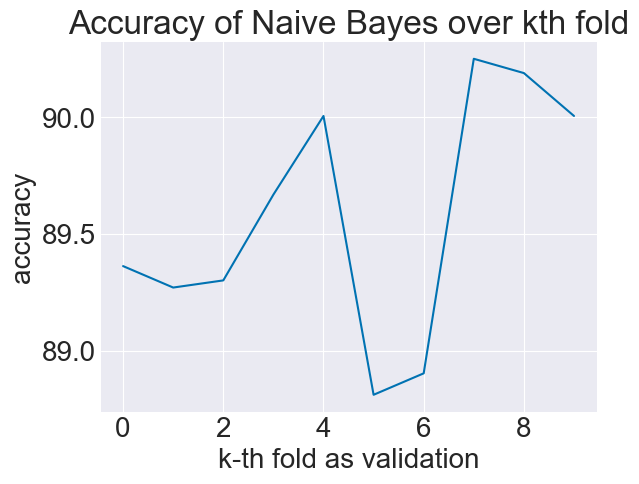

In [90]:
x = np.arange(10)
plt.plot(x, acc)
plt.xlabel("k-th fold as validation")
plt.ylabel("accuracy")
plt.title("Accuracy of Naive Bayes over kth fold")
plt.show()

In [92]:
avg = np.mean(acc)
print("the mean accuracy with k-fold cross validation is", avg, "%")

the mean accuracy with k-fold cross validation is 89.57694665849172 %


With a regular test/train split, we got an accruacy of about 89.24%

With k-fold cross validation, we got a slightly higher average accuracy of about 89.58%

As we can see, the k-fold cross validation technique actually results in a higher accuracy than with a simple test/train split, which means that the way in which we shuffled the test/train probably in fact lowered the accuracy by a little bit. The k-fold cross-validation gives us a less biased accuracy metric because it cross validates against a number of train/test splits which means that we can actually expect our naive bayes to perform better than we thought. 

## Extension: Follow up to k-fold

Doing some more research on k-fold cross validation, I saw that there was some debate on the optimal number of k to choose for k-fold cross validation. To explore this further, I decided to find the optimal choice of k for this specific enron data set and see which would give me the best performance. I explore this from k = 2 to k = 10.

In [96]:
avg_accs = []

for k in range(2,10):
    kfold = NaiveBayes(2)
    acc = kfold.kfold(features, y, k)
    avg_accs.append(np.mean(acc))


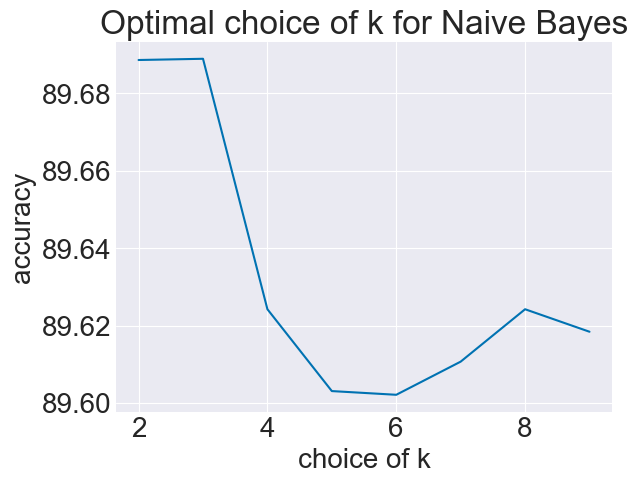

In [97]:
x = np.arange(2,10)
plt.plot(x, avg_accs)
plt.xlabel("choice of k")
plt.ylabel("accuracy")
plt.title("Optimal choice of k for Naive Bayes")
plt.show()

In [102]:
i = np.argmax(avg_accs)
print("We get the highest accuracy of ", avg_accs[i], "%", "at k = ", i + 1)

We get the highest accuracy of  89.68888888888888 % at k =  2


Interestingly enough, in this case, we get the best accuracy of around 89.69% at k = 2.

### 5. Email error analysis

- Dive deeper into the properties of the emails that were misclassified (FP and/or FN) by Naive Bayes or KNN. What is their word composition? How many words were skipped because they were not in the training set? What could plausibly account for the misclassifications?

### 6. Investigate the misclassification errors

Numbers are nice, but they may not the best for developing your intuition. Sometimes, you want to see what an misclassification *actually looks like* to help you improve your algorithm. Retrieve the actual text of some example emails of false positive and false negative misclassifications to see if helps you understand why the misclassification occurred. Here is an example workflow:

- Decide on how many FP and FN emails you would like to retrieve. Find the indices of this many false positive and false negative misclassification. Remember to use your `test_inds` array to look up the index of the emails BEFORE shuffling happened.
- Implement the function `retrieve_emails` in `email_preprocessor.py` to return the string of the raw email at the error indices.
- Call your function to print out the emails that produced misclassifications.

Do the FP and FN emails make sense? Why? Do the emails have properties in common? Can you quantify and interpret them?

### Acknowledgments

https://machinelearningmastery.com/k-fold-cross-validation/ for kfold cross validation